In [21]:
import torch
import torch.nn as nn
from torchaudio.datasets import LIBRISPEECH
from tqdm import tqdm
from torch.optim import Adam

In [22]:
class TruncatedLibri(LIBRISPEECH):
    def __getitem__(self, index):
        waveform, sr, transcript, speakerID, chapterID, utteranceID = super().__getitem__(index)
        waveform = waveform[:, :50000]  # truncate waveform to size 43840 (smalles size in dataset)
        # if waveform shorter than 43840, pad with zeros
        if waveform.shape[1] < 50000:
            #print(index, waveform.shape)
            waveform = torch.cat([waveform, torch.zeros(1, 50000 - waveform.shape[1])], dim=1)
        return waveform, sr, transcript, speakerID, chapterID, utteranceID

train_loader = torch.utils.data.DataLoader(TruncatedLibri('.', download=True), batch_size=1, shuffle=True)


try:
    waveform, sr, transcript, speakerID, chapterID, utteranceID = next(iter(train_loader))
except Exception as e:
    print(e)
    print('May need to downgrade pytorch to 2.0.1')

In [23]:
train_loader.dataset[19719]

(tensor([[0.0000e+00, 3.0518e-05, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 16000,
 "IT WAS HE WHO INVENTED THE ATHLETE'S ADMIRABLE RULES",
 6147,
 34606,
 30)

In [24]:
# find out smallest size of waveform
#min_size = 100000000
#i = 0
#for sample in train_loader:
#    if i % 1000 == 0:
#        print(i)
#    if not sample[1] == 16000:
#        print('sample[1]:', sample[1])
#    if sample[0].shape[-1] < min_size:
#        min_size = sample[0].shape[-1]
#    i += 1

#print('min_size:', min_size)

Sample Rate: 16000


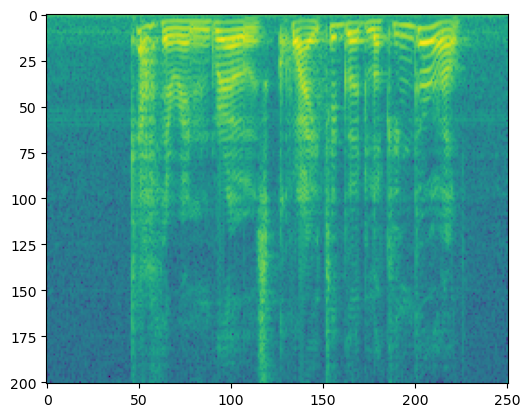

CATHERINE GROWS QUITE A GOOD LOOKING GIRL SHE IS ALMOST PRETTY TODAY WERE WORDS WHICH CAUGHT HER EARS NOW AND THEN AND HOW WELCOME WERE THE SOUNDS TO LOOK ALMOST PRETTY


In [25]:
sound = waveform.flatten()
print('Sample Rate:', sr.item()) 
#convert to spectogram
import torchaudio.transforms as T
spectogram = T.Spectrogram()(sound)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spectogram.log())
plt.show()

print(transcript[0])

# show ipython sound
from IPython.display import Audio
Audio(sound.numpy(), rate=sr.item())



In [26]:
#def h(c):
#    #Wc + b where the hell does this come from?
#    return c 
#
# contrastive loss function
#def contrastive_loss_batch(z, z_tilde, c, lambda_=10):
#    return torch.log(torch.sigmoid(z.T@h(c))) + lambda_* torch.mean(torch.log(torch.sigmoid(-z_tilde.T@h(c))))


In [28]:
# Contrastive learning
#channels = 512
channels = 12

# Encoder
encoder = torch.nn.Sequential(nn.Conv1d(1, channels, kernel_size=10, stride=5), 
                              nn.ReLU(),
                              nn.GroupNorm(1, channels),
                              nn.Conv1d(channels, channels, kernel_size=8, stride=4),
                              nn.ReLU(),
                              nn.GroupNorm(1, channels),
                              nn.Conv1d(channels, channels, kernel_size=4, stride=2),
                              nn.ReLU(),
                              nn.GroupNorm(1, channels),
                              nn.Conv1d(channels, channels, kernel_size=4, stride=2),
                              nn.ReLU(),
                              nn.GroupNorm(1, channels),
                              nn.Conv1d(channels, 1, kernel_size=4, stride=2),
                              nn.ReLU(),
                              nn.GroupNorm(1, 1)
                            )

# Context
layers = [nn.Conv1d(1, channels, kernel_size=3, stride=1, padding='same'), nn.ReLU(), nn.GroupNorm(1, channels)]
for i in range(7):
    layers.append(nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding='same'))
    layers.append(nn.ReLU())
    layers.append(nn.GroupNorm(1, channels))
layers.extend([nn.Conv1d(channels, 1, kernel_size=3, stride=1, padding='same'), nn.ReLU(), nn.GroupNorm(1, 1)])
context = torch.nn.Sequential(*layers)


train_loader = torch.utils.data.DataLoader(TruncatedLibri('.', download=True), batch_size=1, shuffle=True)

def sample_distractors(x, K=10):
    # k = number of distractors
    distractors = torch.zeros((K, 1, x.shape[-1]))
    for k in range(K):
         idxs = torch.randint(0, 272, (x.shape[-1],))
         d = x[:, :, idxs]   
         distractors[k] = d
    return distractors

x = next(iter(train_loader))
x = x[0]
q = encoder(x)
c = context(q)
d = sample_distractors(x)
qtildes = encoder(d)
Q = torch.cat([q, qtildes], dim=0)

def sim(a, b):
    return a@b.T / (torch.norm(a) * torch.norm(b))

def contrastive_loss(q, qtildes, c, Kappa = 0.01):
    sim_pos = sim(q, c)[0]
    sim_neg = sim(qtildes, c)
    loss = -torch.log(sim_pos / Kappa) / torch.sum((sim_neg / Kappa), dim=0)
    return loss

from pytorch_metric_learning import losses

loss_fn = losses.SelfSupervisedLoss(losses.NTXentLoss(temperature=0.1))
loss = loss_fn(c.repeat(qtildes.shape[0]+1, 1, 1).squeeze(1), Q.squeeze(1))
print(loss)

tensor(7.7808, grad_fn=<MeanBackward0>)


In [29]:
# training loop
epochs = 10
num_distractors = 10

optimizer = Adam(list(encoder.parameters()) + list(context.parameters()), lr=0.0001)
for epoch in range(epochs):
    pbar = tqdm(train_loader)
    for sample in pbar:
        x = sample[0]
        q = encoder(x)
        c = context(q)
        d = sample_distractors(x, num_distractors)
        qtildes = encoder(d)
        Q = torch.cat([q, qtildes], dim=0)
        #print(c.shape, qtildes.shape, Q.shape)
        optimizer.zero_grad()
        loss = loss_fn(c.repeat(qtildes.shape[0]+1, 1, 1).squeeze(1), Q.squeeze(1))
        loss.backward()
        optimizer.step()
        pbar.set_description(f'loss: {loss.item():.4f}')

loss: 3.0445:   4%|▍         | 1102/28539 [01:17<32:05, 14.25it/s]  


KeyboardInterrupt: 

48